# SHAP Tutorial for Image Classification

Run all cells in order.

---

## What is SHAP?

**SHAP** unifies several explainability methods under a single theoretical framework based on **Shapley values** from cooperative game theory.

### Key Concepts:

1. **Shapley Values**: Fair distribution of a "payout" (prediction) among "players" (features)
2. **Additive**: SHAP values sum to the difference between prediction and expected value
3. **Theoretically Grounded**: Satisfies desirable properties (local accuracy, missingness, consistency)
4. **Unified Framework**: Connects and improves upon LIME, DeepLIFT, and other methods

### Mathematical Foundation:

For a prediction $f(x)$ and a feature $i$, the Shapley value $\phi_i$ is:

$$\phi_i = \sum_{S \subseteq F \setminus \{i\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f(S \cup \{i\}) - f(S)]$$

Where:
- $F$ = set of all features
- $S$ = subset of features (coalition)
- The formula averages marginal contributions across all possible coalitions

### SHAP Explainers:

1. **GradientExplainer**: Uses gradients (fast, approximate)
2. **DeepExplainer**: Uses DeepLIFT algorithm (accurate for deep networks)
3. **KernelExplainer**: Model-agnostic (slower, like LIME)

### Advantages:
- ✅ Theoretically sound (game theory)
- ✅ Consistent explanations
- ✅ Locally accurate
- ✅ Fast for deep learning (GradientExplainer)

### Disadvantages:
- ❌ Complex interpretation (requires understanding Shapley values)
- ❌ Computational cost for exact values
- ❌ Background distribution matters

---

In [ ]:
# Google Colab Setup (run this cell first!)
import sys

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab - Installing dependencies...")
    !pip install -q torch torchvision shap
    print("Dependencies installed successfully!")
else:
    print("Running locally")

print("Environment ready!")

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import shap
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")
print(f"SHAP version: {shap.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
SHAP version: 0.49.1
CUDA available: True


## 2. Define the CNN Model

Same architecture as LIME tutorial for consistency.

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)  # Softmax for SHAP
        return output

print("Model architecture defined!")

Model architecture defined!


## 3. Load MNIST Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Data directory - works in both Colab and local
data_dir = './data'

print("Loading MNIST dataset...")
train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(data_dir, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Using device: cuda
Loading MNIST dataset...
Training samples: 60000
Test samples: 10000


## 4. Train the Model

In [4]:
def train_model(model, device, train_loader, epochs=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

print("Initializing model...")
model = SimpleCNN().to(device)

print("\nTraining model...")
train_model(model, device, train_loader, epochs=3)
print("Training complete!")

Initializing model...

Training model...


/home/matthewcockayne/.local/lib/python3.10/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/3, Batch 0/938, Loss: 2.3022
Epoch 1/3, Batch 100/938, Loss: 1.6632
Epoch 1/3, Batch 100/938, Loss: 1.6632
Epoch 1/3, Batch 200/938, Loss: 1.5886
Epoch 1/3, Batch 200/938, Loss: 1.5886
Epoch 1/3, Batch 300/938, Loss: 1.6544
Epoch 1/3, Batch 300/938, Loss: 1.6544
Epoch 1/3, Batch 400/938, Loss: 1.5739
Epoch 1/3, Batch 400/938, Loss: 1.5739
Epoch 1/3, Batch 500/938, Loss: 1.5417
Epoch 1/3, Batch 500/938, Loss: 1.5417
Epoch 1/3, Batch 600/938, Loss: 1.5076
Epoch 1/3, Batch 600/938, Loss: 1.5076
Epoch 1/3, Batch 700/938, Loss: 1.4776
Epoch 1/3, Batch 700/938, Loss: 1.4776
Epoch 1/3, Batch 800/938, Loss: 1.4631
Epoch 1/3, Batch 800/938, Loss: 1.4631
Epoch 1/3, Batch 900/938, Loss: 1.5656
Epoch 2/3, Batch 0/938, Loss: 1.5064
Epoch 1/3, Batch 900/938, Loss: 1.5656
Epoch 2/3, Batch 0/938, Loss: 1.5064
Epoch 2/3, Batch 100/938, Loss: 1.4917
Epoch 2/3, Batch 100/938, Loss: 1.4917
Epoch 2/3, Batch 200/938, Loss: 1.4950
Epoch 2/3, Batch 200/938, Loss: 1.4950
Epoch 2/3, Batch 300/938, Loss:

## 5. Evaluate Model

In [5]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        if total >= 1000:
            break

accuracy = 100. * correct / total
print(f"Model Accuracy: {accuracy:.2f}%")

Model Accuracy: 97.40%


## 6. Prepare Data for SHAP

SHAP requires:
1. **Background data**: Reference distribution (representative samples)
2. **Test data**: Instances to explain

In [6]:
print("Preparing background and test samples...")

# Background samples (from training set)
background_samples = []
train_iter = iter(train_loader)
for _ in range(2):  # 128 background samples
    data, _ = next(train_iter)
    background_samples.append(data)
background_data = torch.cat(background_samples, dim=0).to(device)

# Test samples
test_samples = []
test_labels = []
test_iter = iter(test_loader)
for _ in range(3):  # 3 test samples to explain
    data, label = next(test_iter)
    test_samples.append(data)
    test_labels.append(label.item())
test_data = torch.cat(test_samples, dim=0).to(device)

# Get predictions
with torch.no_grad():
    predictions = model(test_data)
    pred_labels = predictions.argmax(dim=1).cpu().numpy()

print(f"Background samples: {background_data.shape}")
print(f"Test samples: {test_data.shape}")
print(f"True labels: {test_labels}")
print(f"Predicted labels: {pred_labels.tolist()}")

Preparing background and test samples...
Background samples: torch.Size([128, 1, 28, 28])
Test samples: torch.Size([3, 1, 28, 28])
True labels: [9, 2, 9]
Predicted labels: [9, 2, 9]


## 7. SHAP Method 1: GradientExplainer

**GradientExplainer** uses gradients to approximate SHAP values quickly.

In [7]:
print("Generating SHAP explanations using GradientExplainer...")

model.eval()
explainer = shap.GradientExplainer(model, background_data)
shap_values_gradient = explainer.shap_values(test_data)

print(f"✓ SHAP values computed!")
print(f"Structure: {len(shap_values_gradient)} samples")
print(f"Shape per sample: {shap_values_gradient[0].shape}")

Generating SHAP explanations using GradientExplainer...
✓ SHAP values computed!
Structure: 3 samples
Shape per sample: (1, 28, 28, 10)
✓ SHAP values computed!
Structure: 3 samples
Shape per sample: (1, 28, 28, 10)


### Visualize GradientExplainer Results

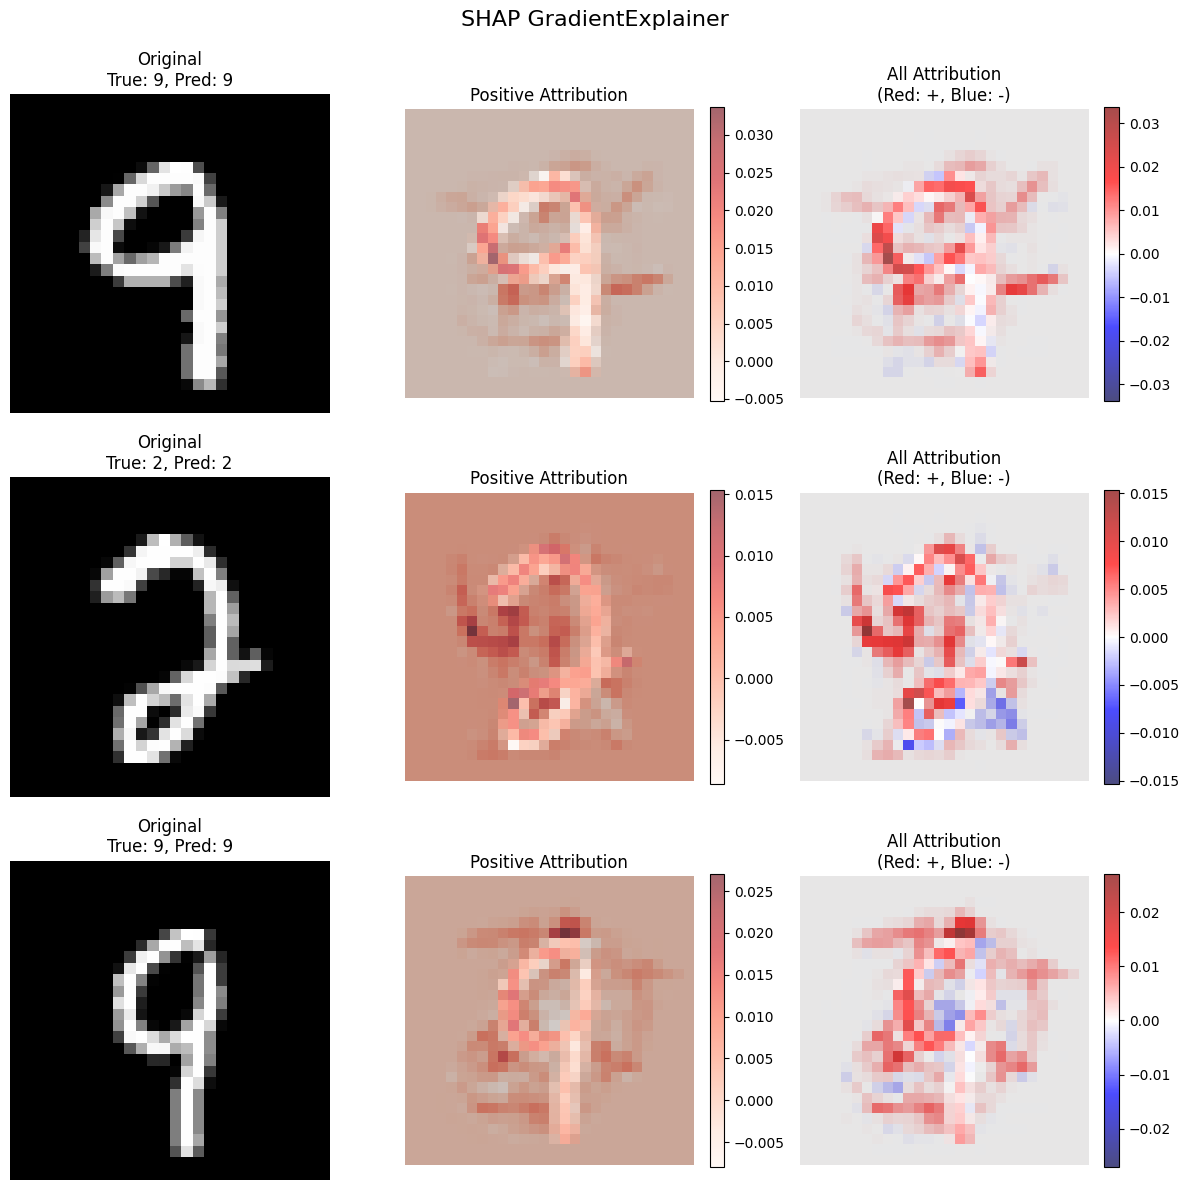

✓ Saved GradientExplainer visualizations


In [ ]:
output_dir = Path('./results/shap')
output_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for idx in range(3):
    image = test_samples[idx].squeeze().cpu().numpy()
    pred_class = pred_labels[idx]
    true_class = test_labels[idx]
    
    # Extract SHAP values for predicted class
    shap_array = np.array(shap_values_gradient[idx])
    if len(shap_array.shape) == 4:
        shap_img = shap_array[0, :, :, pred_class]
    else:
        shap_img = shap_array[:, :, pred_class]
    
    # Original
    axes[idx, 0].imshow(image, cmap='gray')
    axes[idx, 0].set_title(f'Original\nTrue: {true_class}, Pred: {pred_class}')
    axes[idx, 0].axis('off')
    
    # Positive attribution
    axes[idx, 1].imshow(image, cmap='gray', alpha=0.5)
    im1 = axes[idx, 1].imshow(shap_img, cmap='Reds', alpha=0.6)
    axes[idx, 1].set_title('Positive Attribution')
    axes[idx, 1].axis('off')
    plt.colorbar(im1, ax=axes[idx, 1], fraction=0.046)
    
    # All attribution
    axes[idx, 2].imshow(image, cmap='gray', alpha=0.3)
    im2 = axes[idx, 2].imshow(shap_img, cmap='seismic', alpha=0.7,
                              vmin=-np.abs(shap_img).max(),
                              vmax=np.abs(shap_img).max())
    axes[idx, 2].set_title('All Attribution\n(Red: +, Blue: -)')
    axes[idx, 2].axis('off')
    plt.colorbar(im2, ax=axes[idx, 2], fraction=0.046)

plt.suptitle('SHAP GradientExplainer', fontsize=16, y=0.99)
plt.tight_layout()
plt.savefig(output_dir / 'shap_gradient_explanations.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved GradientExplainer visualizations")

## 8. SHAP Method 2: DeepExplainer

**DeepExplainer** uses the DeepLIFT algorithm for more accurate attributions.

In [9]:
print("Generating SHAP explanations using DeepExplainer...")

model.eval()
explainer = shap.DeepExplainer(model, background_data)
shap_values_deep = explainer.shap_values(test_data, check_additivity=False)

print("✓ SHAP values computed!")

Generating SHAP explanations using DeepExplainer...
✓ SHAP values computed!


### Visualize DeepExplainer Results

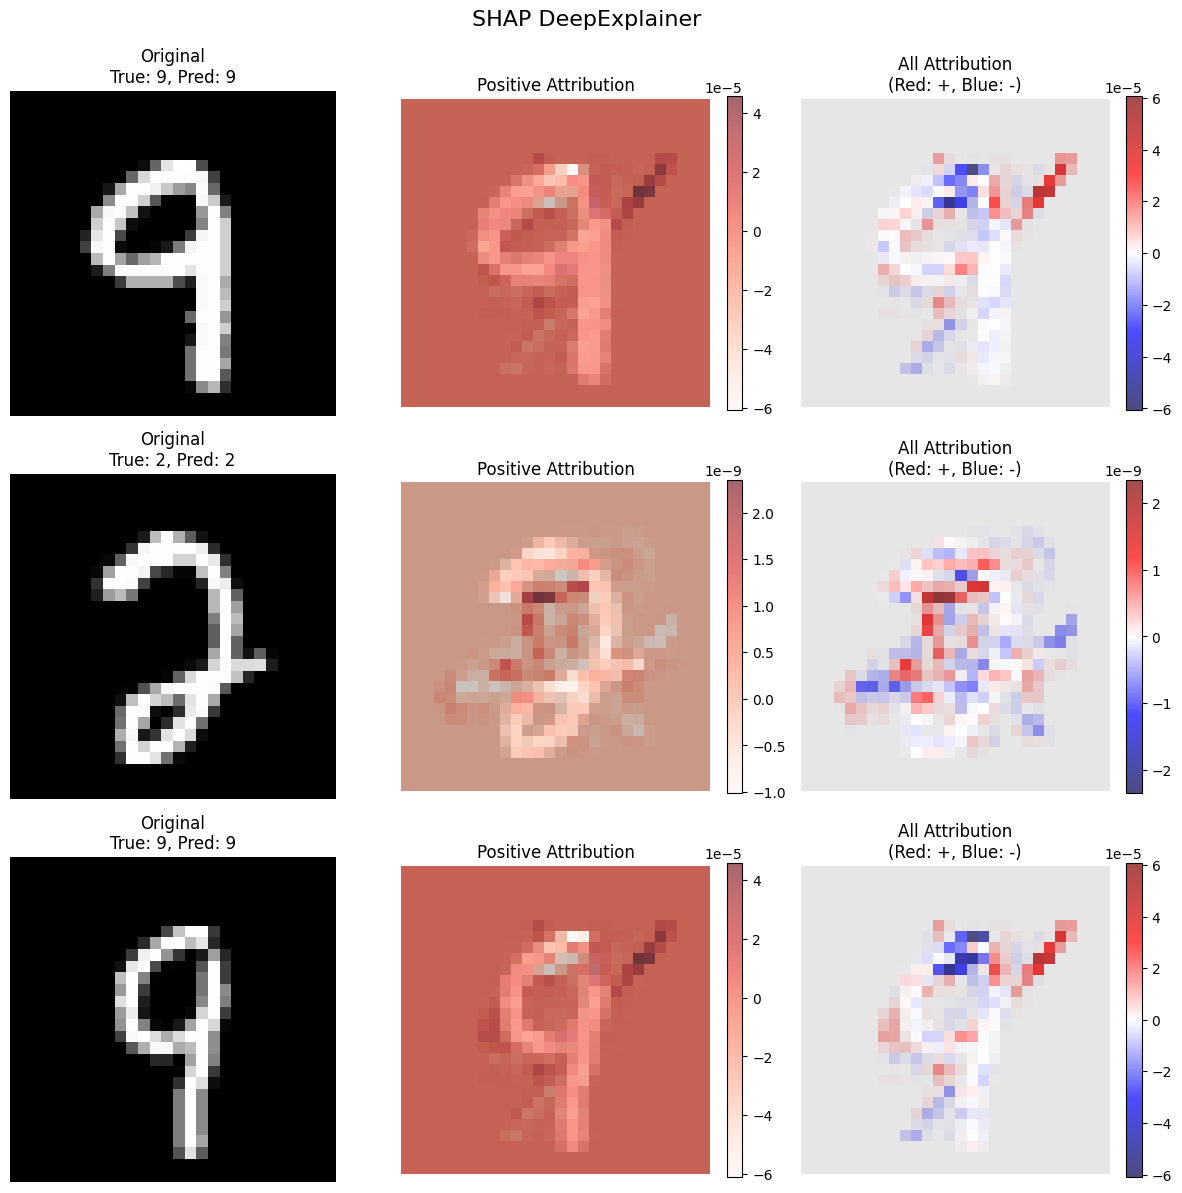

✓ Saved DeepExplainer visualizations


In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for idx in range(3):
    image = test_samples[idx].squeeze().cpu().numpy()
    pred_class = pred_labels[idx]
    true_class = test_labels[idx]
    
    # Extract SHAP values for predicted class
    shap_array = np.array(shap_values_deep[idx])
    if len(shap_array.shape) == 4:
        shap_img = shap_array[0, :, :, pred_class]
    else:
        shap_img = shap_array[:, :, pred_class]
    
    # Original
    axes[idx, 0].imshow(image, cmap='gray')
    axes[idx, 0].set_title(f'Original\nTrue: {true_class}, Pred: {pred_class}')
    axes[idx, 0].axis('off')
    
    # Positive attribution
    axes[idx, 1].imshow(image, cmap='gray', alpha=0.5)
    im1 = axes[idx, 1].imshow(shap_img, cmap='Reds', alpha=0.6)
    axes[idx, 1].set_title('Positive Attribution')
    axes[idx, 1].axis('off')
    plt.colorbar(im1, ax=axes[idx, 1], fraction=0.046)
    
    # All attribution
    axes[idx, 2].imshow(image, cmap='gray', alpha=0.3)
    im2 = axes[idx, 2].imshow(shap_img, cmap='seismic', alpha=0.7,
                              vmin=-np.abs(shap_img).max(),
                              vmax=np.abs(shap_img).max())
    axes[idx, 2].set_title('All Attribution\n(Red: +, Blue: -)')
    axes[idx, 2].axis('off')
    plt.colorbar(im2, ax=axes[idx, 2], fraction=0.046)

plt.suptitle('SHAP DeepExplainer', fontsize=16, y=0.99)
plt.tight_layout()
plt.savefig(output_dir / 'shap_deep_explanations.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved DeepExplainer visualizations")

## 9. Compare Both Methods

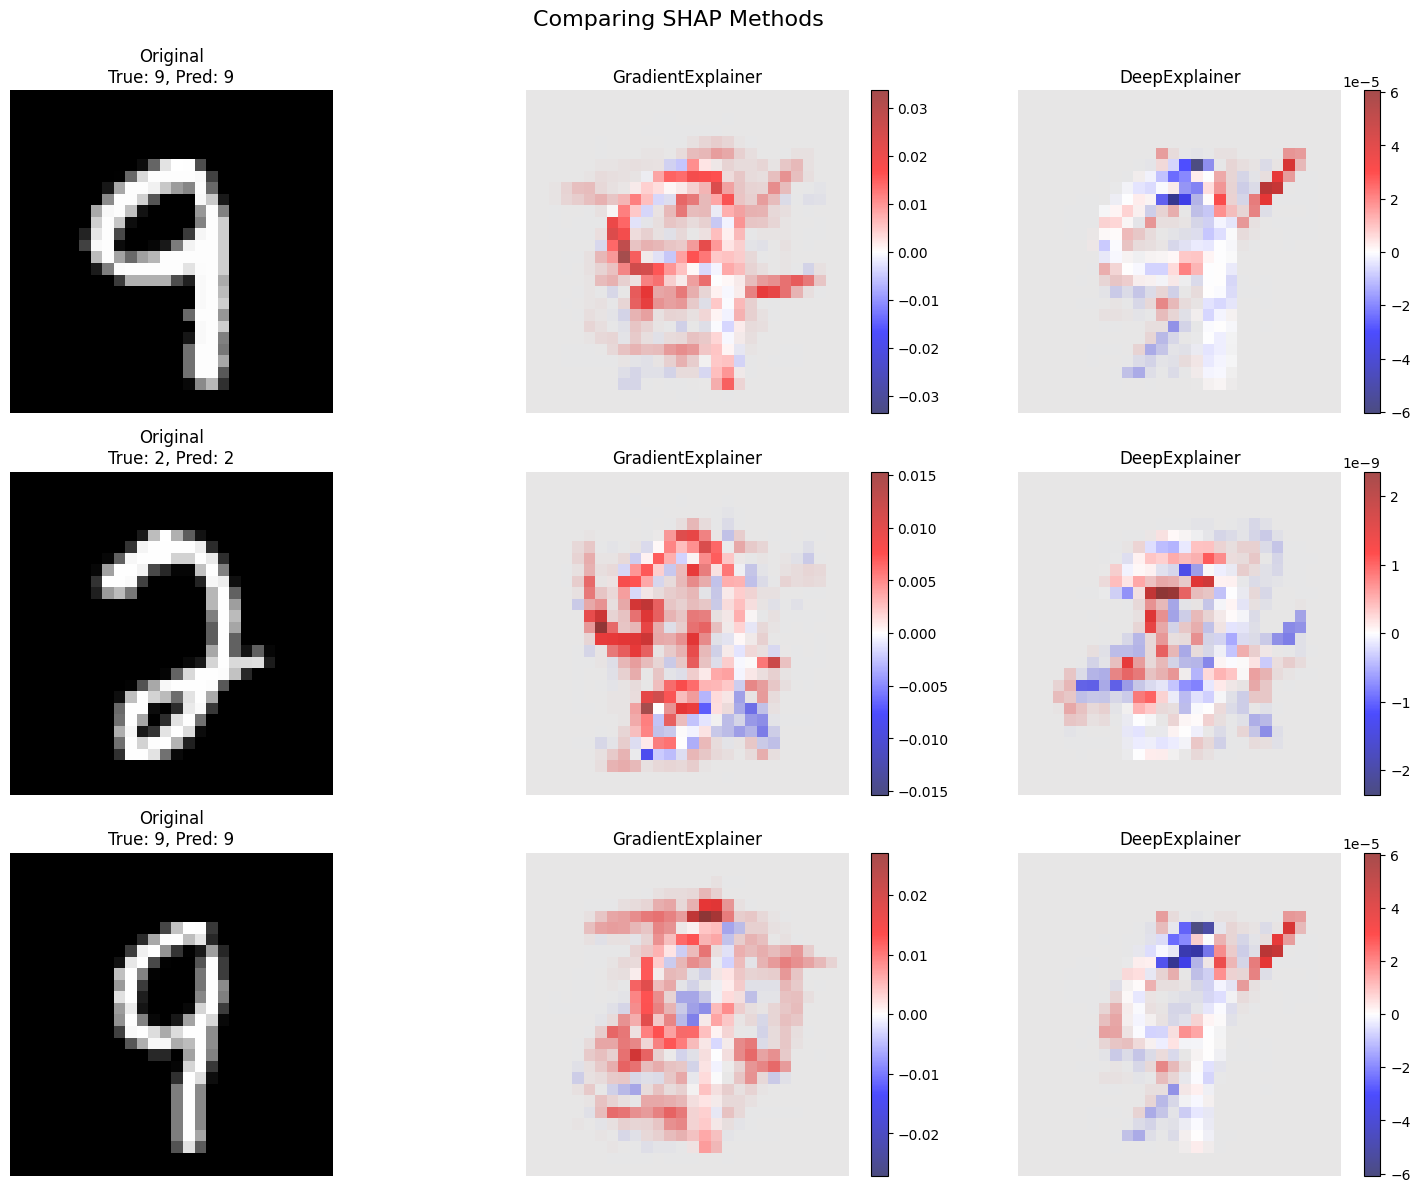

✓ Saved comparison visualization


In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for idx in range(3):
    image = test_samples[idx].squeeze().cpu().numpy()
    pred_class = pred_labels[idx]
    true_class = test_labels[idx]
    
    # Original
    axes[idx, 0].imshow(image, cmap='gray')
    axes[idx, 0].set_title(f'Original\nTrue: {true_class}, Pred: {pred_class}')
    axes[idx, 0].axis('off')
    
    # GradientExplainer
    shap_grad_array = np.array(shap_values_gradient[idx])
    shap_grad = shap_grad_array[0, :, :, pred_class] if len(shap_grad_array.shape) == 4 else shap_grad_array[:, :, pred_class]
    
    axes[idx, 1].imshow(image, cmap='gray', alpha=0.3)
    im1 = axes[idx, 1].imshow(shap_grad, cmap='seismic', alpha=0.7,
                              vmin=-np.abs(shap_grad).max(),
                              vmax=np.abs(shap_grad).max())
    axes[idx, 1].set_title('GradientExplainer')
    axes[idx, 1].axis('off')
    plt.colorbar(im1, ax=axes[idx, 1], fraction=0.046)
    
    # DeepExplainer
    shap_deep_array = np.array(shap_values_deep[idx])
    shap_deep = shap_deep_array[0, :, :, pred_class] if len(shap_deep_array.shape) == 4 else shap_deep_array[:, :, pred_class]
    
    axes[idx, 2].imshow(image, cmap='gray', alpha=0.3)
    im2 = axes[idx, 2].imshow(shap_deep, cmap='seismic', alpha=0.7,
                              vmin=-np.abs(shap_deep).max(),
                              vmax=np.abs(shap_deep).max())
    axes[idx, 2].set_title('DeepExplainer')
    axes[idx, 2].axis('off')
    plt.colorbar(im2, ax=axes[idx, 2], fraction=0.046)

plt.suptitle('Comparing SHAP Methods', fontsize=16, y=0.99)
plt.tight_layout()
plt.savefig(output_dir / 'shap_methods_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved comparison visualization")

## 10. Summary

### Key Takeaways:

1. **SHAP provides theoretically-grounded explanations** based on Shapley values from game theory
2. **Additive property**: SHAP values sum to prediction difference from baseline
3. **Red regions** = positive contribution (increase prediction for target class)
4. **Blue regions** = negative contribution (decrease prediction for target class)
5. **Two methods compared**:
   - **GradientExplainer**: Fast, uses gradients
   - **DeepExplainer**: More accurate, uses DeepLIFT

### When to Use SHAP:
- ✅ Need theoretically sound explanations
- ✅ Want consistent, reproducible attributions
- ✅ Need fast explanations (GradientExplainer)
- ✅ Comparing feature importance across instances

### SHAP vs LIME:

| Aspect | SHAP | LIME |
|--------|------|------|
| **Theory** | Game theory (Shapley values) | Local linear approximation |
| **Speed** | Fast (GradientExplainer) | Slow (~1000 samples) |
| **Consistency** | Yes (same input → same output) | No (stochastic) |
| **Additivity** | Yes (values sum to prediction) | No |
| **Interpretation** | Feature contributions | Feature importance |

### Mathematical Properties:

SHAP satisfies three desirable properties:

1. **Local Accuracy**: $f(x) = \phi_0 + \sum_{i=1}^M \phi_i$
2. **Missingness**: $x_i = 0 \Rightarrow \phi_i = 0$
3. **Consistency**: If model changes so feature contributes more, attribution shouldn't decrease

### Next Steps:
- Try **GradCAM** for faster gradient-based explanations
- Experiment with different background distributions
- Use SHAP summary plots for global feature importance
- Compare with LIME to understand different perspectives

---

**All visualizations saved to**: `./results/shap/`